<a href="https://colab.research.google.com/github/juliaronquetti/Modelo_predicao_SP/blob/main/5_imoveis_ML_best_model_numeric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
start_time = time.time()

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

path = 'https://github.com/juliaronquetti/Modelo_predicao_SP/blob/main/'

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error

import statsmodels.api as sm

In [ ]:
def error_metrics(y_true, y_pred):

  metrics = {}

  metrics['R2'] = np.round(r2_score(y_true, y_pred),2)
  metrics['RMSE'] = root_mean_squared_error(y_true, y_pred).round(2)
  metrics['MAE'] = mean_absolute_error(y_true, y_pred).round(2)
  metrics['MedAE'] = median_absolute_error(y_true, y_pred).round(2)
  metrics['MAPE'] = mean_absolute_percentage_error(y_true, y_pred).round(2)

  return metrics

In [ ]:
def cv_metrics(cv_results,grid_search):

  metrics = {}

  metrics['R2'] = cv_results['mean_test_R2'][grid_search.best_index_].round(2)
  metrics['RMSE'] = cv_results['mean_test_RMSE'][grid_search.best_index_].round(2)
  metrics['MAE'] = cv_results['mean_test_MAE'][grid_search.best_index_].round(2)
  metrics['MedAE'] = cv_results['mean_test_MedAE'][grid_search.best_index_].round(2)
  metrics['MAPE'] = cv_results['mean_test_MAPE'][grid_search.best_index_].round(2)

  return metrics

In [ ]:
from IPython.display import display, Latex, HTML
import warnings

def gera_df_stats_latex(df_stats, titulo):

  warnings.filterwarnings('ignore')
  # latex_table = df_stats.style.to_latex(hrules=True)
  latex_table = df_stats.to_latex(index=None)
  # display(Latex(latex_table))

  latex_table = latex_table.replace('tabular','array')
  latex_table = latex_table.replace('toprule','hline')
  latex_table = latex_table.replace('midrule','hline')
  latex_table = latex_table.replace('bottomrule','hline')

  latex_table = '\\textbf{' + titulo + '} \\\\' + latex_table

  warnings.filterwarnings('default')
  return latex_table

In [ ]:
def plot_results(y_true, y_pred, titulo, qmin=0, qmax=1, qqplot=True, title_result=True):
  import statsmodels.api as sm
  import scipy.stats as stats

  fig, ax = plt.subplots(2,2,figsize=(10,10))
  ax = ax.flatten()

  if title_result:
    erro = error_metrics(y_true, y_pred)['MAPE']/2
    plt.suptitle(titulo + f'\n Preços $\\pm$ {erro:.2f}%',fontsize=14,weight='bold')
  else:
    plt.suptitle(titulo,fontsize=14,weight='bold')

  lim_min = min(np.quantile(y_true, qmin),np.quantile(y_pred, qmin))
  lim_max = max(np.quantile(y_true, qmax),np.quantile(y_pred, qmax))
  ax[0].set_xlim([lim_min,lim_max])
  ax[0].set_ylim([lim_min,lim_max])

  ax[0].scatter(y_true, y_pred, alpha=0.2, s=10)
  ax[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--')
  ax[0].set_xlabel('Preços Reais $y$')
  ax[0].set_ylabel('Preços Previstos $y_{pred}$')
  ax[0].set_title('Preços Reais $y$ $\\times$ Preços Previstos $y_{pred}$',weight='bold')
  # Adicione um quadro com as métricas de erro
  metrics_text = '\n'.join([f"{key}: {value}" for key, value in error_metrics(y_true, y_pred).items()])
  ax[0].text(ax[0].get_xlim()[1]*0.08, ax[0].get_ylim()[1]*0.7, metrics_text, fontsize=10)

  ax[1].scatter(y_true, y_true - y_pred, alpha=0.2, s=10)
  ax[1].axhline(y=0, color='r', linestyle='--')
  ax[1].set_xlabel('Instâncias')
  ax[1].set_ylabel('Erro')
  ax[1].set_title('Erro $(y - y_{pred})$',weight='bold')

  sns.kdeplot(x = y_true - y_pred, alpha=0.2, ax=ax[2], color='blue',fill='blue')
  ax[2].set_xlabel('Erro')
  ax[2].set_ylabel('Freq')
  ax[2].set_title('Distribuição do Erro',weight='bold')

  if qqplot:
    # QQ plot for residuals
    stats.probplot(y_true - y_pred, dist="norm", plot=ax[3])
    ax[3].set_title('QQ Plot dos Resíduos',weight='bold')
  else:
    ax[3].scatter(y, np.abs((y_true - y_pred)) / y_true, alpha=0.2, s=10)
    ax[3].axhline(y=0, color='r', linestyle='--')
    ax[3].set_xlabel('Instâncias')
    ax[3].set_ylabel('MAPE')
    ax[3].set_title('MAPE $abs(y - y_{pred})/y$',weight='bold')

  plt.tight_layout()
  plt.show()


# Data

In [ ]:
df = pd.read_csv(path + 'imoveis_clean_encoded.csv')

# if you want test with few records
# np.random.seed(42)
# df = df.iloc[ np.random.choice(df.index, size=1000, replace=False) ]

# selecionar a zona
# df = df[ df.zona_SUL == 1 ].reset_index(drop=True)
# df.drop(columns=['zona_LESTE','zona_NORTE','zona_OESTE','zona_SUL'])

# selecionar quartos
# df = df[ df.quartos == 3 ].reset_index(drop=True)
# df.drop(columns=['quartos'])

df.head()

,title,price,location,destaque,condominio,area_util,quartos,banheiros,vagas_na_garagem,iptu,academia,elevador,permitido_animais,piscina,portaria,salao_de_festas,condominio_fechado,seguranca_24h,portao_eletronico,area_murada,area_de_servico,armarios_na_cozinha,armarios_no_quarto,churrasqueira,mobiliado,quarto_de_servico,ar_condicionado,porteiro_24h,varanda,img_index,categoria_Casas,tipo_Casa de vila,tipo_Cobertura,tipo_Duplex ou triplex,tipo_Kitnet,tipo_Loft,tipo_Padrão,zona_LESTE,zona_NORTE,zona_OESTE,zona_SUL
0,Apartamento MOBILIADO com ÓTIMA Localização Ág...,350000,859,1,380,43,2,1,0,0,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
1,"Apartamento 115.000,00",115000,454,1,150,50,2,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0
2,Casa de condomínio sobrado para venda com 97 m...,570000,328,0,320,97,3,3,2,19,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,4,1,0,0,0,0,0,0,0,0,1,0
3,"Cobertura com 3 dormitórios (1 suíte) á venda,...",2250000,2,0,1790,163,3,4,3,616,1,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,5,0,0,1,0,0,0,0,0,0,1,0
4,CASA TERREA NO JARDIM BONFIGLIOLI COM 3 DORMI...,820000,150,0,0,167,3,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1,0,0,0,0,0,1,0,0,1,0


# GridSearchCV definitions and start results history

In [ ]:
%%time
# Some GridSearchCV definitions
# scoring
scoring = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'MedAE': make_scorer(median_absolute_error),
    'MAPE': make_scorer(mean_absolute_percentage_error),
}

# CV k folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results_dict = {} # starts results history empty

CPU times: user 768 µs, sys: 0 ns, total: 768 µs
Wall time: 773 µs


# Select Features

In [ ]:
%%time
from sklearn.feature_selection import mutual_info_classif

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)

X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate mutual information
mutual_info = mutual_info_classif(X_train, y_train, random_state=42)

# Create a DataFrame to store feature names and their mutual information scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Mutual Information': mutual_info})

# Sort the DataFrame by mutual information in descending order
feature_importance_df = feature_importance_df.sort_values('Mutual Information', ascending=False)

# Display the feature importance
display(feature_importance_df)

df.drop(columns=list(feature_importance_df['Feature'].tolist()[-5::]), inplace=True)

print()
print('Features deleted: ', feature_importance_df['Feature'].tolist()[-5::])

,Feature,Mutual Information
3,area_util,1.091157
2,condominio,1.077962
33,tipo_Padrão,1.061211
5,banheiros,0.982277
4,quartos,0.888522
7,iptu,0.875165
6,vagas_na_garagem,0.829180
0,location,0.805296
10,permitido_animais,0.495432
13,salao_de_festas,0.381610



Features deleted:  ['porteiro_24h', 'portao_eletronico', 'tipo_Casa de vila', 'quarto_de_servico', 'destaque']
CPU times: user 37.6 s, sys: 314 ms, total: 38 s
Wall time: 38.4 s


# Machine Learning Estimator

In [ ]:
# modelo = GradientBoostingRegressor(n_estimators=1000, random_state=42)
modelo = RandomForestRegressor(n_estimators=1000, random_state=42)
model_name = type(modelo).__name__
print(model_name)

RandomForestRegressor


# Machine Learning: Numeric

In [ ]:
%%time
test_name = 'Numeric Fields'

df_model = df.copy()
df_model.drop(['title','img_index'], axis=1, inplace=True)

X = df_model.drop('price', axis=1)
y = df_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# numeric transformer = StandardScaler
numeric_features = df_model.drop('price', axis=1).select_dtypes(include=['number']).columns.tolist()
numeric_transformer = StandardScaler()

# combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

# pipeline com pré-processamento e modelo
model = make_pipeline(preprocessor, modelo)

# model parameters
param_grid = {}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1  # utilize todos os núcleos do processador
)

# train GridSearchCV
grid_search.fit(X_train, y_train)

# Check
print(model_name, modelo, grid_search.best_params_)
print()

results_dict[model_name + ' ' + test_name + ' (CV)'] = cv_metrics(grid_search.cv_results_,grid_search)

y_pred = grid_search.predict(X_test)
results_dict[model_name + ' ' + test_name + ' (test)'] = error_metrics(y_test, y_pred)

grid_search.fit(X, y)
y_pred = grid_search.predict(X)
results_dict[model_name + ' ' + test_name + ' (all)'] = error_metrics(y, y_pred)

# exibe resultados
results_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=['R2', 'RMSE', 'MAE', 'MedAE', 'MAPE'])
display(results_df.reset_index().rename(columns={'index':'Model'}).style.set_properties(**{'text-align': 'left'}).format({
    'R2': "{:.2f}",
    'RMSE': "{:.2f}",
    'MAE': "{:.2f}",
    'MedAE': "{:.2f}",
    'MAPE': "{:.2f}"
}))

print()



RandomForestRegressor RandomForestRegressor(n_estimators=1000, random_state=42) {}



/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,R2,RMSE,MAE,MedAE,MAPE
0,RandomForestRegressor Numeric Fields (CV),0.83,275130.31,170054.07,93674.15,0.20
1,RandomForestRegressor Numeric Fields (test),0.84,264916.95,158845.77,82369.57,0.18
2,RandomForestRegressor Numeric Fields (all),0.98,95300.42,57290.74,29912.10,0.07



CPU times: user 4min 33s, sys: 3.42 s, total: 4min 36s
Wall time: 20min 15s


## Plot results

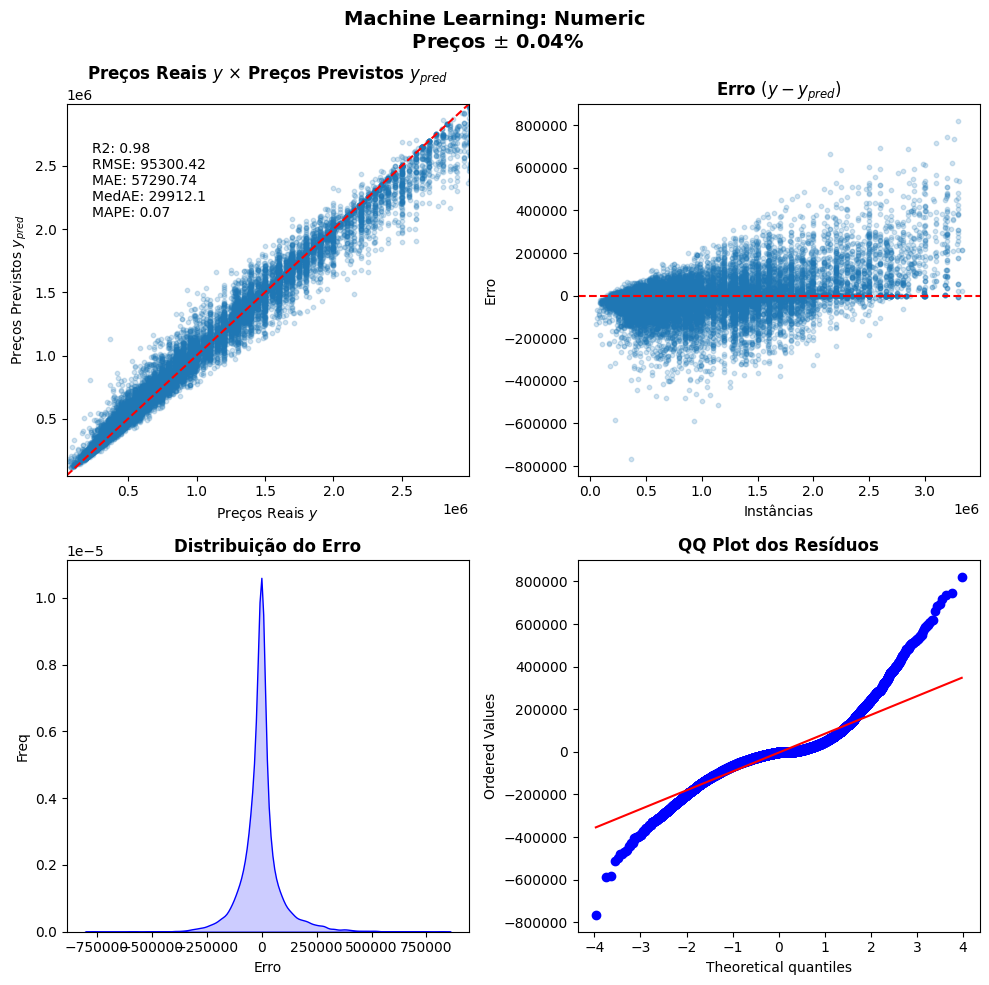

In [ ]:
plot_results(y, y_pred, 'Machine Learning: Numeric', qmax=0.99)

In [ ]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Tempo de execução: {execution_time/60:.2f} min")

# Save results

In [ ]:
from google.colab import files

results_df.to_csv('imoveis_results_ML_numeric_text.csv', index=None)
files.download('imoveis_results_ML_numeric_text.csv')